# Test SIR epidemiology models for pyciemss

In [52]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

from copy import copy

from torchdiffeq import odeint, odeint_adjoint

import torch
from torch import nn

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.nn.module import to_pyro_module_
from pyro.poutine import trace
from pyro.infer.autoguide.guides import AutoDelta,  AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive

##  SciPy ODEint SIR model

/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_28826/540095618.py:37: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


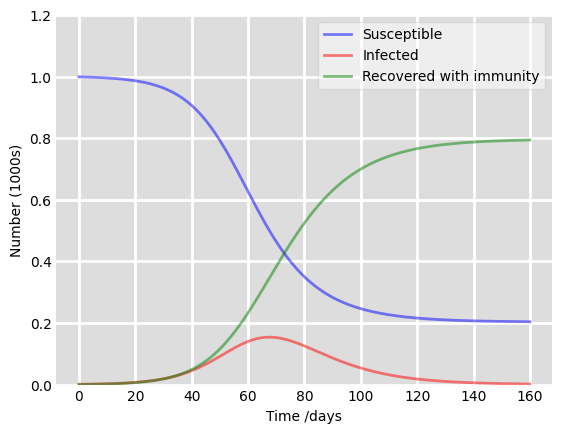

In [4]:

# Total population, N.
N = 1000.0
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1.0, 0.0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = scipy.integrate.odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## TorchDiffEq ODEInt for SIR (no adjoint)

In [5]:


class SIR(nn.Module):
    def __init__(self, params, initial_state, adjoint=False):
        super().__init__()
        self.N, self.beta, self.gamma = [nn.Parameter(torch.as_tensor(p)) for p in params]
        self.S0, self.I0, self.R0 = [nn.Parameter(torch.as_tensor(x0)) for x0 in initial_state]
        self.t0 = nn.Parameter(torch.tensor([0.0]))
        self.odeint = odeint_adjoint if adjoint else odeint
    
    def get_tspan(self, start, end, steps):
        return torch.linspace(float(start), float(end), steps)
        
    def forward(self, t, state):
        S, I, R = state
        dSdt = -self.beta * S * I / self.N
        dIdt = self.beta * S * I / self.N - self.gamma * I
        dRdt = self.gamma * I
        return dSdt, dIdt, dRdt
    
    def get_initial_state(self):
        return self.S0, self.I0, self.R0
    
    def get_params(self):
        return self.N, self.beta, self.gamma
    

In [6]:
sir = SIR((N, beta, gamma), (S0, I0, R0), adjoint=False)
solution = sir.odeint(sir, sir.get_initial_state(), sir.get_tspan(0, 160, 160))
S, I, R = [s.detach().numpy() for s in solution]
N, beta, gamma = sir.get_params()

/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_28826/3602944340.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


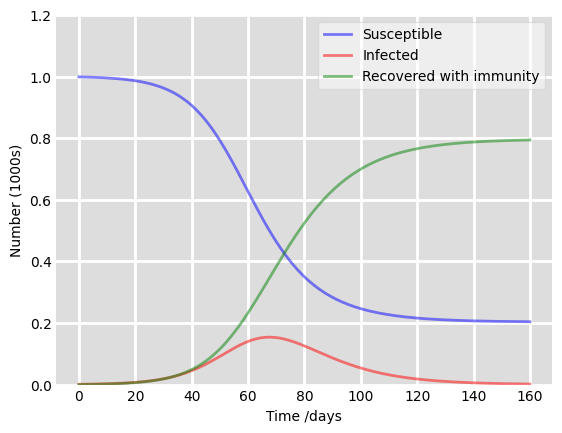

In [7]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## TorchDiffEq ODEInt for SIR (adjoint)

In [8]:
sir_adj = SIR((N, beta, gamma), (S0, I0, R0), adjoint=True)
solution = sir_adj.odeint(sir_adj, sir_adj.get_initial_state(), sir_adj.get_tspan(0, 160, 160))
S, I, R = [s.detach().numpy() for s in solution]
N, beta, gamma = sir_adj.get_params()

/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_28826/3602944340.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


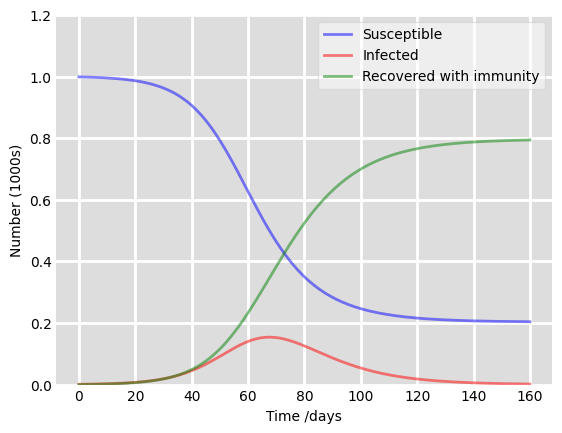

In [9]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

# Test SVIIvR epidemiology model for PyCIEMSS

![SVIIvR](img/sviivr.png)

## SciPy ODE model SVIIvR model

/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_28826/3765871469.py:41: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


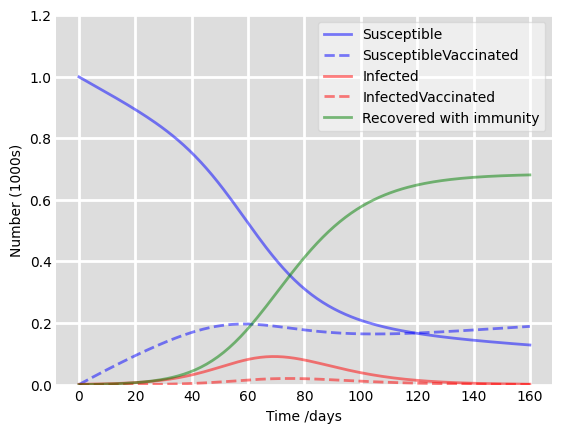

In [10]:

# Total population, N.
N = 1000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0,  = 0.0, 1.0, 0.0, 0.0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 -V0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, betaV, gamma, gammaV, nu = 0.2, 0.15, 1./10, 1.5/10, 0.005 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def SVIIvR(y, t, N, beta, betaV, gamma, gammaV, nu):
    S, V, I, Iv, R = y
    dSdt = -beta  * S * I  / N - beta   * S * Iv / N - nu * S 
    dVdt = -betaV * V * Iv / N - betaV  * V * I  / N + nu * S
    dIdt =  beta  * S * I  / N  + beta  * S * Iv / N - gamma  * I 
    dIvdt = betaV * V * I / N   + betaV * V * Iv / N - gammaV * Iv 
    dRdt =  gamma * I + gammaV * Iv
    return dSdt, dVdt, dIdt, dIvdt, dRdt

# Initial conditions vector
y0 = S0, V0, I0, Iv0, R0
# Integrate the SVIIvR equations over the time grid, t.
ret = scipy.integrate.odeint(SVIIvR, y0, t, args=(N, beta, betaV, gamma, gammaV, nu))
S, V, I, Iv, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, V/1000, 'b--', alpha=0.5, lw=2, label='SusceptibleVaccinated')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, Iv/1000, 'r--', alpha=0.5, lw=2, label='InfectedVaccinated')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## TorchDiffEq ODEInt for SVIIvR model (no adjoint)

In [11]:


# Total population, N.
N = 1000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0,  = 0.0, 1.0, 0.0, 0.0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 -V0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, betaV, gamma, gammaV, nu = 0.2, 0.15, 1./10, 1.5/10, 0.005 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)
class SVIIvR(nn.Module):
    def __init__(self, params, initial_state, adjoint=False):
        super().__init__()
        self.N, self.beta, self.betaV, self.gamma, self.gammaV, self.nu = [nn.Parameter(torch.as_tensor(p)) for p in params]
        self.S0,  self.V0, self.I0, self.Iv0, self.R0  = [nn.Parameter(torch.as_tensor(x0)) for x0 in initial_state]
        self.t0 = nn.Parameter(torch.tensor([0.0]))
        self.odeint = odeint_adjoint if adjoint else odeint
        
    def forward(self, t, state):
        S, V, I, Iv, R = state
        dSdt = -self.beta  * S * I  / self.N - self.beta   * S * Iv / self.N - self.nu * S 
        dVdt = -self.betaV * V * Iv / self.N - self.betaV  * V * I  / self.N + self.nu * S
        dIdt =  self.beta  * S * I  / self.N  + self.beta  * S * Iv / self.N - self.gamma  * I 
        dIvdt = self.betaV * V * I / self.N   + self.betaV * V * Iv / self.N - self.gammaV * Iv 
        dRdt =  self.gamma * I + self.gammaV * Iv

        return dSdt, dVdt, dIdt, dIvdt, dRdt
    
    def get_tspan(self, start, end, steps):
        return torch.linspace(float(start), float(end), steps)
    
    def get_initial_state(self):
        return self.S0, self.V0, self.I0, self.Iv0, self.R0
    
    def get_params(self):
        return self.N, self.beta, self.betaV, self.gamma, self.gammaV, self.nu
    

In [12]:
sviivr = SVIIvR((N, beta, betaV, gamma, gammaV, nu), (S0, V0, I0, Iv0, R0), adjoint=False)
solution = sviivr.odeint(sviivr, sviivr.get_initial_state(), sviivr.get_tspan(0, 160, 160))
S, V, I, Iv, R = [s.detach().numpy() for s in solution]
N, beta, betaV, gamma, gammaV, nu = sviivr.get_params()

/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_28826/3324673236.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


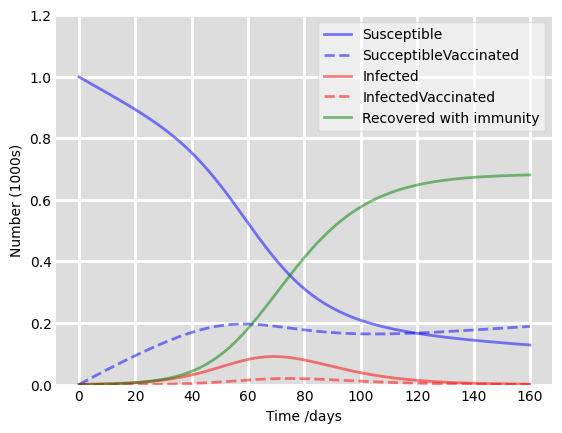

In [13]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, V/1000, 'b--', alpha=0.5, lw=2, label='SucceptibleVaccinated')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, Iv/1000, 'r--', alpha=0.5, lw=2, label='InfectedVaccinated')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## TorchDiffEq ODEInt for SVIIvR model (adjoint)

In [25]:
sviivr_adj = SVIIvR((N, beta, betaV, gamma, gammaV, nu), (S0, V0, I0, Iv0, R0), adjoint=True)
tspan = sviivr_adj.get_tspan(0, 160, 160)
solution = sviivr_adj.odeint(sviivr_adj, sviivr_adj.get_initial_state(), tspan)
S, V, I, Iv, R = [s.detach().numpy() for s in solution]
N, beta, betaV, gamma, gammaV, nu = sviivr_adj.get_params()

/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_28826/3324673236.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


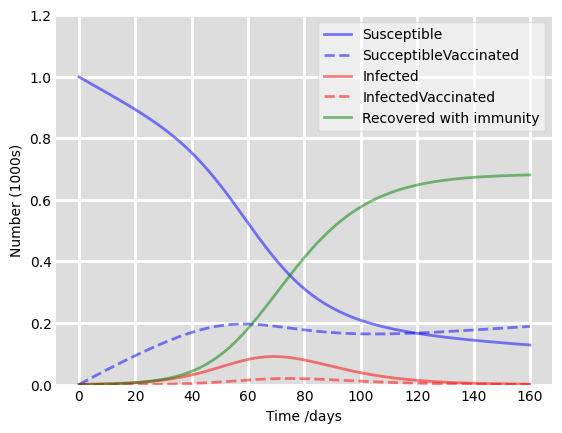

In [26]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, V/1000, 'b--', alpha=0.5, lw=2, label='SucceptibleVaccinated')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, Iv/1000, 'r--', alpha=0.5, lw=2, label='InfectedVaccinated')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Put model into pyro with observational noise

In [161]:
class ODESolution(PyroModule):
    def __init__(self, bayesian_ode, observation_model):
        super().__init__()
        self.bayesian_ode = bayesian_ode
        self.observation_model = observation_model
        
    def forward(self, tspan, data=None):
        solution = self.bayesian_ode.odeint(self.bayesian_ode, self.bayesian_ode.get_initial_state(), tspan)
        observations = self.observation_model(solution, data)
        return observations

In [162]:
class GaussianNoise(PyroModule):
    def __init__(self, noise_variance, solution_var_names):
        super().__init__()
        self.noise_variance = noise_variance
        self.solution_var_names = solution_var_names

    def forward(self, solution, data):

        if data == None:
            data = {n: None for n in self.solution_var_names}

        return [pyro.sample(self.solution_var_names[i], dist.Normal(solution[i], self.noise_variance).to_event(1), obs=data[self.solution_var_names[i]]) for i in range(len(solution))]

In [163]:
bayesian_sviivr = copy(sviivr)
to_pyro_module_(bayesian_sviivr)
bayesian_sviivr.beta = PyroSample(dist.Uniform(0, beta+0.1))
bayesian_sviivr.betaV = PyroSample(dist.Uniform(0, betaV+0.1))
bayesian_sviivr.gamma = PyroSample(dist.Uniform(0, gamma+0.1))
bayesian_sviivr.gammaV = PyroSample(dist.Uniform(0, gammaV+0.1))
bayesian_sviivr.nu = PyroSample(dist.Uniform(0, nu+0.001))

In [164]:
gaussian_observation_model = GaussianNoise(10., ["S", "V", "I", "Iv", "R"])

In [165]:
sviivr_solution_model = ODESolution(bayesian_sviivr, gaussian_observation_model)
sol_tr = trace(sviivr_solution_model).get_trace(bayesian_sviivr.get_tspan(0, 160, 160))
observations = sol_tr.nodes["_RETURN"]["value"]
S, V, I, Iv, R = [s.detach() for s in observations]
data = {"S":S, "V":V, "I":I, "Iv":Iv, "R":R}

In [175]:
def plot_predictive(prediction, data, title=""):

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    vars = ["S", "V", "I", "Iv", "R"]
    S, V, I, Iv, R = [data[v].detach().numpy()/1000 for v in vars]

    S_low, V_low, I_low, Iv_low, R_low = [torch.quantile(prediction[k], 0.01, dim=0).detach().numpy()/1000 for k in vars]
    S_up, V_up, I_up, Iv_up, R_up = [torch.quantile(prediction[k], 0.99, dim=0).detach().numpy()/1000 for k in vars]

    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.fill_between(t, S_low, S_up, color='b', alpha=0.2)
    ax.plot(t, V, 'purple', alpha=0.5, lw=2, label='SucceptibleVaccinated')
    ax.fill_between(t, V_low, V_up, color='purple', alpha=0.2)
    ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
    ax.fill_between(t, I_low, I_up, color='r', alpha=0.2)
    ax.plot(t, Iv, 'green', alpha=0.5, lw=2, label='InfectedVaccinated')
    ax.fill_between(t, Iv_low, Iv_up, color='green', alpha=0.2)
    ax.plot(t, R, 'orange', alpha=0.5, lw=2, label='Recovered')
    ax.fill_between(t, R_low, R_up, color='orange', alpha=0.2)
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.title(title)
    plt.show()

In [178]:
prior_prediction = Predictive(sviivr_solution_model, num_samples=100)(tspan)

/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_28826/1446969421.py:27: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


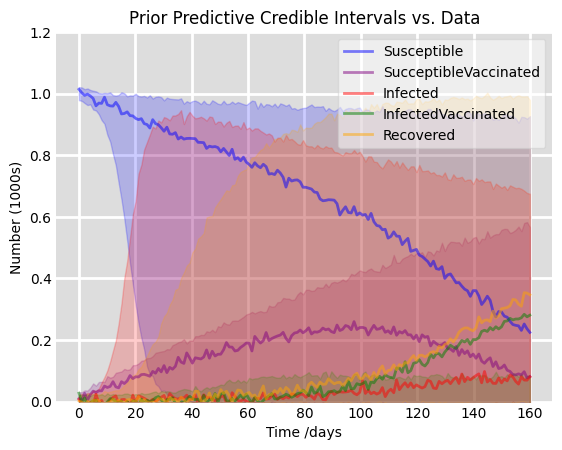

In [179]:
plot_predictive(prior_prediction, data, title="Prior Predictive Credible Intervals vs. Data")

## Condition on (Synthetic) Data and run inference with SVI

In [180]:
# Optimization parameters used throughout
adam = pyro.optim.Adam({'lr': 0.03})
elbo = pyro.infer.Trace_ELBO(num_particles=1)

In [181]:
def run_inference(model, guide, tspan, data, optim=adam, loss=elbo, num_iterations=250, verbose=False):
    svi = SVI(model, guide, optim, loss=loss)

    pyro.clear_param_store()

    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(tspan, data)
        if verbose:
            if j % 50 == 0:
                print("[iteration %04d] loss: %.4f" % (j + 1, loss))

In [182]:
guide = AutoNormal(sviivr_solution_model)
run_inference(sviivr_solution_model, guide, tspan, data, verbose=True)

[iteration 0001] loss: 36458.8041
[iteration 0051] loss: 34546.3384


In [ ]:
posterior_prediction = Predictive(sviivr_solution_model, guide=guide, num_samples=100)(tspan)

dict_keys(['bayesian_ode.beta', 'bayesian_ode.nu', 'bayesian_ode.betaV', 'bayesian_ode.gamma', 'bayesian_ode.gammaV', 'S', 'V', 'I', 'Iv', 'R'])

/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_28826/1932823477.py:27: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


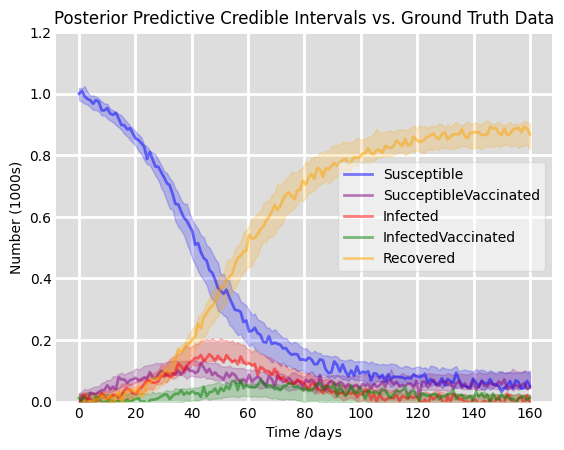

In [ ]:
plot_predictive(posterior_prediction, data, title="Posterior Predictive Credible Intervals vs. Data")